# SESSION 11 - Project on Object Detection - Part I

TOC <br>
```PART I```
1. Setup
2. Install
3. Imports
4. Model preparation <br>
    4.1 Loader<br>
    4.2 Loading label map<br>

**```Real-time object detection and tracking```** is a vast, vibrant yet inconclusive and complex area of computer vision. Due to its increased utilization in surveillance, tracking system used in security and many others applications have propelled researchers to continuously devise more efficient and competitive algorithms. The latest research on this area has been making great progress in many directions.  In the current manuscript, we give an overview of the necessity of object detection in today’s computing systems, outline the current main research directions, discuss on how our API algorithm works, and discuss open problems and possible future directions.
Key words: - Object Detection, Computer Vision, Tracking Systems, API algorithm.

## 1. Setup

Packages to be installed:
```
  1. pip install protobuf
  2. pip install pillow
  3. pip install lxml
  4. pip install Cython
  5. pip install jupyter
  6. pip install matplotlib
  7. pip install pandas
  8. pip install opencv-python 
  9. pip install tensorflow
  
```

## 2. Install

```pip install -U --pre tensorflow=="2.*"```

Make sure you have `pycocotools` installed

```pip install pycocotools```

#### Python Implementation

Get `tensorflow/models` or `cd` to parent directory of the repository.

In [1]:
import os
import pathlib


if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

Cloning into 'models'...
Updating files:   2% (100/3487)
Updating files:   3% (105/3487)
Updating files:   4% (140/3487)
Updating files:   4% (171/3487)
Updating files:   5% (175/3487)
Updating files:   6% (210/3487)
Updating files:   6% (236/3487)
Updating files:   7% (245/3487)
Updating files:   8% (279/3487)
Updating files:   9% (314/3487)
Updating files:  10% (349/3487)
Updating files:  11% (384/3487)
Updating files:  11% (393/3487)
Updating files:  12% (419/3487)
Updating files:  13% (454/3487)
Updating files:  14% (489/3487)
Updating files:  15% (524/3487)
Updating files:  15% (556/3487)
Updating files:  16% (558/3487)
Updating files:  17% (593/3487)
Updating files:  18% (628/3487)
Updating files:  19% (663/3487)
Updating files:  19% (677/3487)
Updating files:  20% (698/3487)
Updating files:  21% (733/3487)
Updating files:  22% (768/3487)
Updating files:  23% (803/3487)
Updating files:  24% (837/3487)
Updating files:  25% (872/3487)
Updating files:  25% (877/3487)
Updating files:

Compile protobufs and install the object_detection package

In [2]:
%%bash
cd models/research/
object_detection/protos/*.proto --python_out=.

Couldn't find program: 'bash'


In [3]:
%%bash 
cd models/research
pip install .

Couldn't find program: 'bash'


## 3. Imports

In [2]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
from IPython.display import display

Import the object detection module.

In [ ]:
from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

Patches:

In [17]:
# patch tf1 into `utils.ops`
utils_ops.tf = tf.compat.v1

# Patch the location of gfile
tf.gfile = tf.io.gfile

# 4. Model preparation 

## Variables

Any model exported using the `export_inference_graph.py` tool can be loaded here simply by changing the path.

By default we use an "SSD with Mobilenet" model here. See the [detection model zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md) for a list of other models that can be run out-of-the-box with varying speeds and accuracies.

## 4.1 Loader

In [18]:
def load_model(model_name):
  base_url = 'http://download.tensorflow.org/models/object_detection/'
  model_file = model_name + '.tar.gz'
  model_dir = tf.keras.utils.get_file(
    fname=model_name, 
    origin=base_url + model_file,
    untar=True)

  model_dir = pathlib.Path(model_dir)/"saved_model"

  model = tf.saved_model.load(str(model_dir))
  model = model.signatures['serving_default']

  return model

## 4.2 Loading label map
Label maps map indices to category names, so that when our convolution network predicts `5`, we know that this corresponds to `airplane`.  Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine

In [19]:
# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = 'models/research/object_detection/data/mscoco_label_map.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

For the sake of simplicity we will test on 2 images:

In [20]:
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = pathlib.Path('models/research/object_detection/test_images')
TEST_IMAGE_PATHS = sorted(list(PATH_TO_TEST_IMAGES_DIR.glob("*.jpg")))
TEST_IMAGE_PATHS

[WindowsPath('models/research/object_detection/test_images/image1.jpg'),
 WindowsPath('models/research/object_detection/test_images/image2.jpg')]

# 5. Detection

5.1 Load an object detection model:

In [21]:
model_name = 'ssd_mobilenet_v1_coco_2017_11_17'
detection_model = load_model(model_name)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


5.2 Check the model's input signature, it expects a batch of 3-color images of type uint8: 

In [22]:
print(detection_model.inputs)

[<tf.Tensor 'image_tensor:0' shape=(None, None, None, 3) dtype=uint8>]


And retuns several outputs:

In [23]:
detection_model.output_dtypes

{'detection_scores': tf.float32,
 'detection_classes': tf.float32,
 'num_detections': tf.float32,
 'detection_boxes': tf.float32}

In [24]:
detection_model.output_shapes

{'detection_scores': TensorShape([None, 100]),
 'detection_classes': TensorShape([None, 100]),
 'num_detections': TensorShape([None]),
 'detection_boxes': TensorShape([None, 100, 4])}

5.3 Add a wrapper function to call the model, and cleanup the outputs:

In [25]:
def run_inference_for_single_image(model, image):
  image = np.asarray(image)
  # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
  input_tensor = tf.convert_to_tensor(image)
  # The model expects a batch of images, so add an axis with `tf.newaxis`.
  input_tensor = input_tensor[tf.newaxis,...]

  # Run inference
  output_dict = model(input_tensor)

  # All outputs are batches tensors.
  # Convert to numpy arrays, and take index [0] to remove the batch dimension.
  # We're only interested in the first num_detections.
  num_detections = int(output_dict.pop('num_detections'))
  output_dict = {key:value[0, :num_detections].numpy() 
                 for key,value in output_dict.items()}
  output_dict['num_detections'] = num_detections

  # detection_classes should be ints.
  output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)
   
  # Handle models with masks:
  if 'detection_masks' in output_dict:
    # Reframe the the bbox mask to the image size.
    detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
              output_dict['detection_masks'], output_dict['detection_boxes'],
               image.shape[0], image.shape[1])      
    detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5,
                                       tf.uint8)
    output_dict['detection_masks_reframed'] = detection_masks_reframed.numpy()
    
  return output_dict

5.4 Run it on each test image and show the results:

In [26]:
def show_inference(model, image_path):
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = np.array(Image.open(image_path))
  # Actual detection.
  output_dict = run_inference_for_single_image(model, image_np)
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks_reframed', None),
      use_normalized_coordinates=True,
      line_thickness=8)

  display(Image.fromarray(image_np))

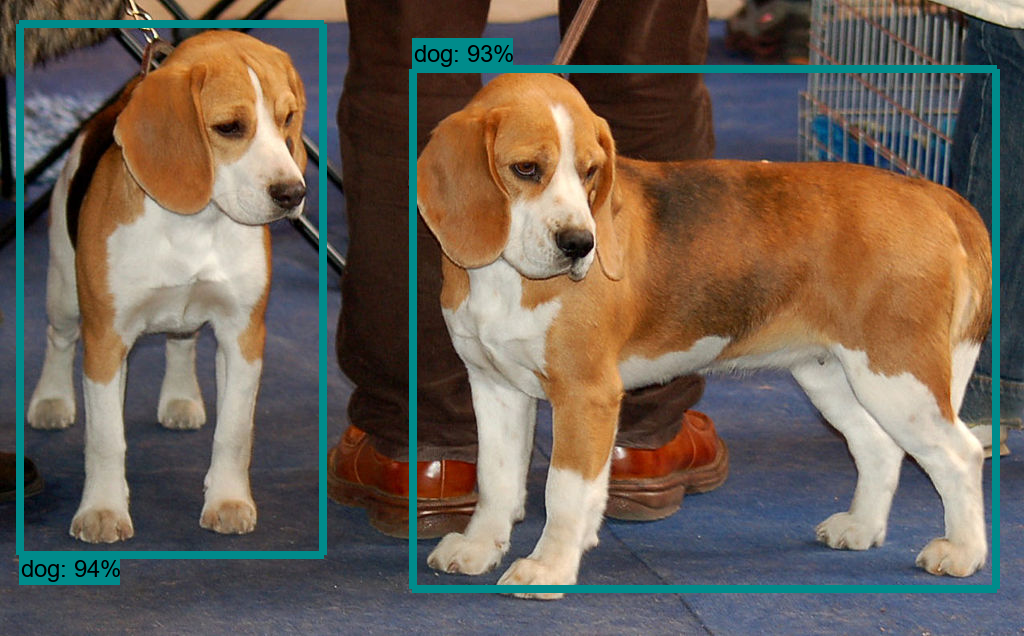

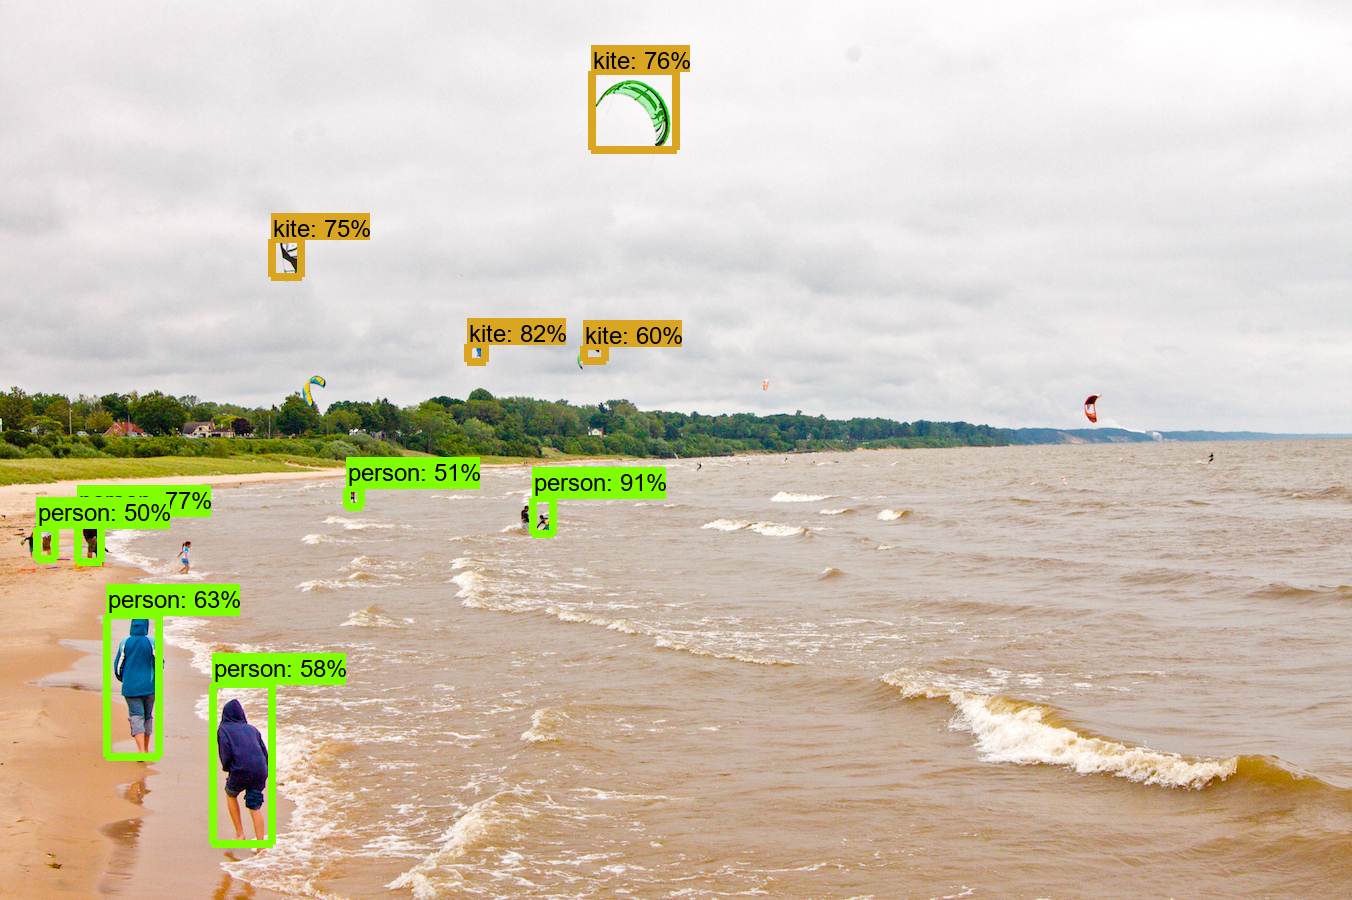

In [27]:
for image_path in TEST_IMAGE_PATHS:
  show_inference(detection_model, image_path)


## 6. Instance Segmentation

In [28]:
model_name = "mask_rcnn_inception_resnet_v2_atrous_coco_2018_01_28"
masking_model = load_model("mask_rcnn_inception_resnet_v2_atrous_coco_2018_01_28")

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


The instance segmentation model includes a `detection_masks` output:

In [29]:
masking_model.output_shapes

{'detection_scores': TensorShape([None, 100]),
 'detection_classes': TensorShape([None, 100]),
 'detection_masks': TensorShape([None, None, None, None]),
 'num_detections': TensorShape([None]),
 'detection_boxes': TensorShape([None, 100, 4])}

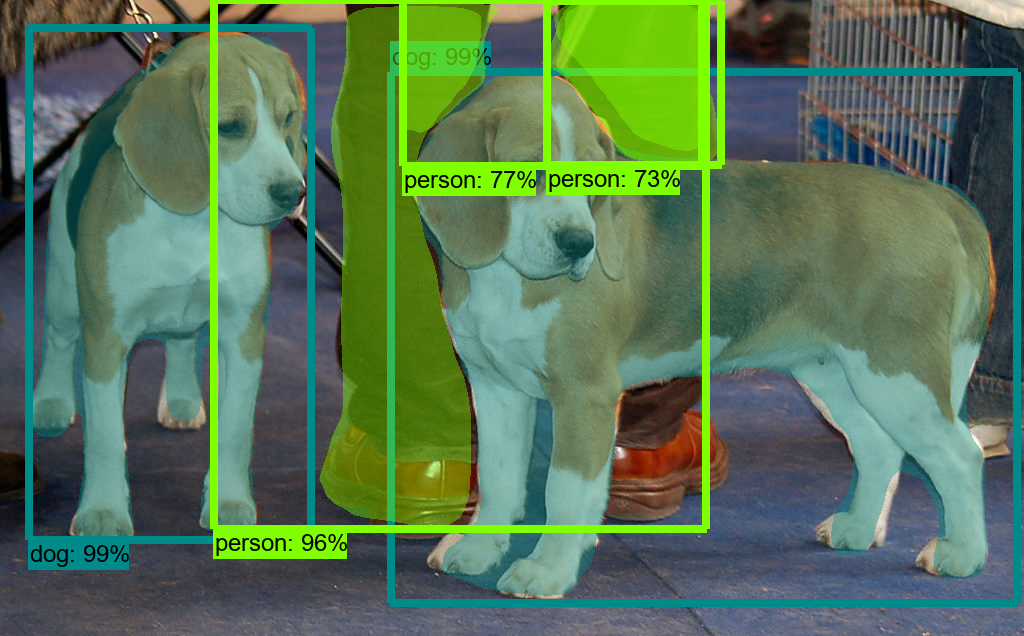

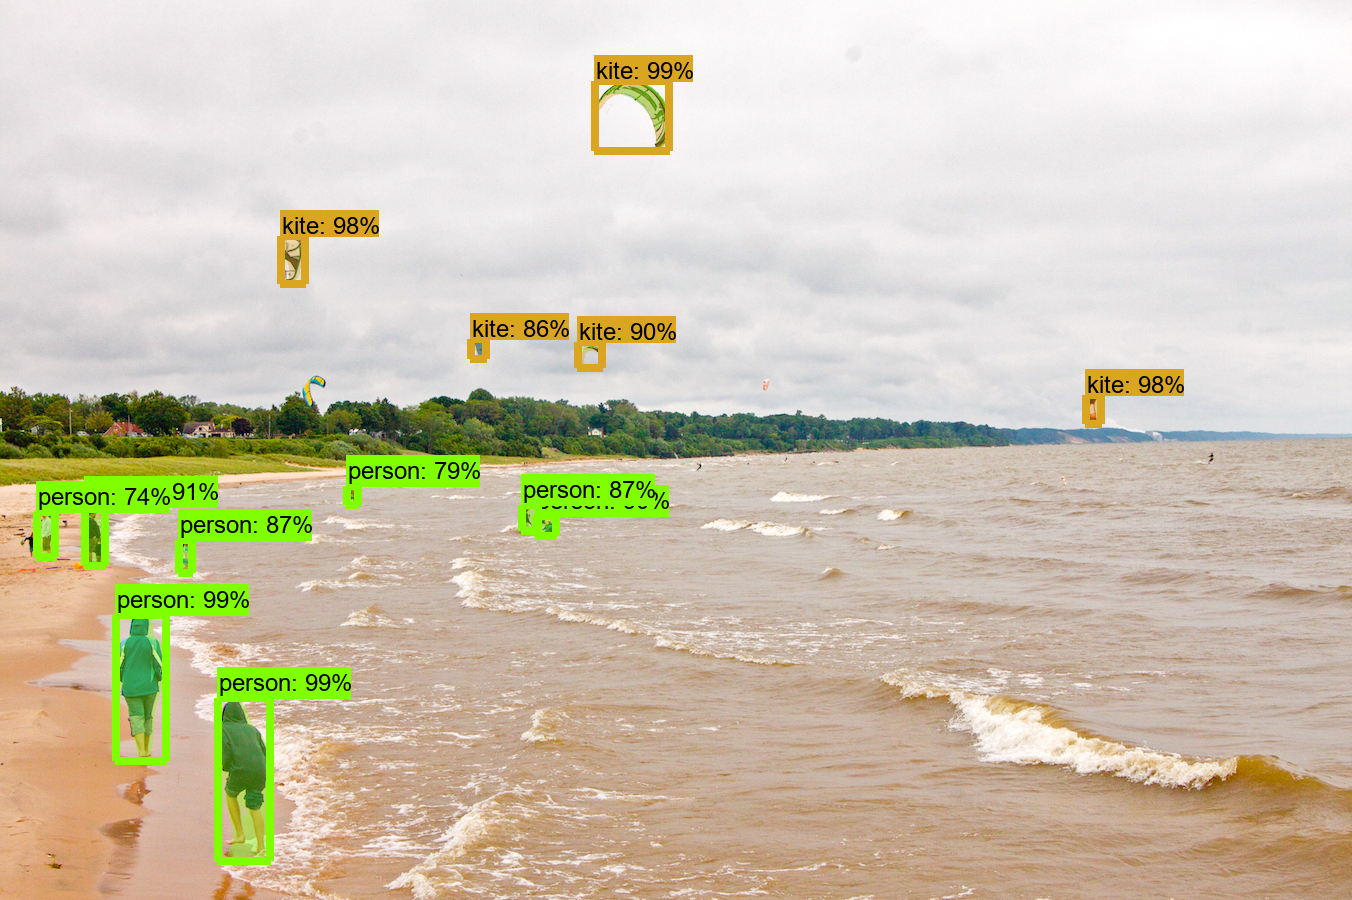

In [30]:
for image_path in TEST_IMAGE_PATHS:
  show_inference(masking_model, image_path)

<hr>